This notebook building on what Deniz did in her regression notebook.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
import seaborn as sns

In [2]:
# refresh instances of ml models
def models_4():
    lr = LinearRegression()
    lasso = Lasso(alpha=.001)
    ridge = Ridge(alpha=20)
    rf = RandomForestRegressor(max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=500)
    return lr, lasso, ridge, rf

def models_3():
    lasso = Lasso(alpha=.001)
    ridge = Ridge(alpha=20)
    rf = RandomForestRegressor(max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=500)
    return lasso, ridge, rf

In [3]:
data = pd.read_csv('Numerical_train.csv')

In [4]:
y = data['SalePrice']
y_log = np.log(data['SalePrice'])

In [5]:
data = data.drop(labels = ['SalePrice', 'Id'], axis=1).astype("float64")

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.3, random_state = 42)

In [7]:
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(data, y_log, test_size = 0.3, random_state = 42)

lets look at the 4 models using log(price) as target and the data is normalized

In [8]:
for name, model in zip(['lr', 'lasso', 'ridge', 'rf'],
                       [*models_4()]):
    pipeline = Pipeline([('scaler', StandardScaler()), ('estimator', model)])
    pipeline.fit(X_train_log, y_train_log)
    print(name + ' train R-squared: ' + str(pipeline.score(X_train_log, y_train_log)))
    print(name + ' test R-squared: ' + str(pipeline.score(X_test_log, y_test_log)))

lr train R-squared: 0.937942350321315
lr test R-squared: -2.4619975878687486e+22
lasso train R-squared: 0.9325428885383787
lasso test R-squared: 0.8611374476318673
ridge train R-squared: 0.9313019631265858
ridge test R-squared: 0.873487221819156
rf train R-squared: 0.9727948390613691
rf test R-squared: 0.8817371948143998


better yet - lets use cross validation!

In [9]:
scores_compare = {}

In [10]:
for name, model in zip(['lr', 'lasso', 'ridge', 'rf'],
                       [*models_4()]):
    pipeline = Pipeline([('scaler', StandardScaler()), ('estimator', model)])
    scores = cross_validate(pipeline, data, y_log, cv=3, scoring=['r2', 'neg_mean_squared_error'])

    print(name, 'r2', scores['test_r2'].mean())
    scores_compare[name + '_log_std'] = scores['test_r2'].mean()
    print(name, 'rmse', np.sqrt(np.abs(scores['test_neg_mean_squared_error'])).mean())
    print('\n')

lr r2 -6.896293225145098e+21
lr rmse 20824726622.986958


lasso r2 0.835499500908426
lasso rmse 0.16134844870879697


ridge r2 0.8541745583165307
ridge rmse 0.15201545605678132


rf r2 0.8666077533709012
rf rmse 0.14573644782897333




Lets compare scaled data with log target vs. regular target, we did log(target) already so lets look at the models using the target as is.

In [11]:
for name, model in zip(['lr', 'lasso', 'ridge', 'rf'],
                       [*models_4()]):
    pipeline = Pipeline([('scaler', StandardScaler()), ('estimator', model)])
    scores = cross_validate(pipeline, data, y, cv=3, scoring=['r2', 'neg_mean_squared_error'])
    print(name, 'r2', scores['test_r2'].mean())
    print(name, 'rmse', np.sqrt(np.abs(scores['test_neg_mean_squared_error'])).mean())
    print('\n')

lr r2 -6.110287554020952e+20
lr rmse 1490499321762289.5




/Users/tovaschwartz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 250482600279.18225, tolerance: 623665273.6123221
  positive)
/Users/tovaschwartz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 204174015976.39096, tolerance: 590567335.9139535
  positive)
/Users/tovaschwartz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 233723267263.68542, tolerance: 627039530.279152
  positive)


lasso r2 0.685220484098683
lasso rmse 43122.23726417757


ridge r2 0.8081222046759079
ridge rmse 34535.30547773449


rf r2 0.8521056056933887
rf rmse 30365.542242424406




Using log of the data does improve the model, some models show a more dramatic improvement than others.
#### Upshot: use log for target

Seems like log model produces better results, what happens if we dont standardize the data

In [12]:
for name, model in zip(['lr', 'lasso', 'ridge', 'rf'],[*models_4()]):
    scores = cross_validate(model, data, y_log, cv=3, scoring=['r2', 'neg_mean_squared_error']);
    print(name, 'r2', scores['test_r2'].mean())
    scores_compare[name + '_log'] = scores['test_r2'].mean()
    print(name, 'rmse', np.sqrt(np.abs(scores['test_neg_mean_squared_error'])).mean())
    print('\n')

lr r2 0.8102368925158484
lr rmse 0.1725222649078778


lasso r2 0.8643349060276883
lasso rmse 0.14588115860365736


ridge r2 0.8654232915945355
ridge rmse 0.145485359398667


rf r2 0.8673238879692261
rf rmse 0.14536635744377713




We see that standardizing makes sense for all models but doesnt effect the RandomForest which is what makes sense.

#### Bottum line is : best results were achieve from RandomForest using log(target) and unstandardized data, followed closesly by ridge and lasso working on standardized data. Its safe to forget about the basic LinearRegression. And lets only use log(target)

Now lets look at models with fewer features...

In [13]:
top_6_features = ['GrLivArea', 'OverallQual', 'TotalBsmtSF', 'GarageArea', '1stFlrSF', 'YearBuilt']

In [14]:
data_6 = data.loc[:, top_6_features]

In [15]:
for name, model in zip(['lasso', 'ridge', 'rf'],
                       [*models_3()]):
    if name == 'rf':
        pipeline = Pipeline([('scaler', None), ('estimator', model)])
    else:
        pipeline = Pipeline([('scaler', StandardScaler()), ('estimator', model)])
    scores = cross_validate(pipeline, data_6, y_log, cv=3, scoring=['r2', 'neg_mean_squared_error'])
    
    print(name, 'r2', scores['test_r2'].mean())
    print(name, 'rmse', np.sqrt(np.abs(scores['test_neg_mean_squared_error'])).mean())
    print('\n')

lasso r2 0.7973448807832164
lasso rmse 0.1787884997422181


ridge r2 0.7976103136465328
ridge rmse 0.1786667206971746


rf r2 0.8294435549128872
rf rmse 0.16477461636801696




In [16]:
print(scores_compare['lasso_log_std'], scores_compare['ridge_log_std'], scores_compare['rf_log'])

0.835499500908426 0.8541745583165307 0.8673238879692261


By going from 100+ variables to just 6 we only lose a few percentage points! Lets see if theres a perfect medium...

In [17]:
rf = RandomForestRegressor(max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=500)
rf.fit(X_train_log, y_train_log)
feature_importances = sorted(zip(X_train.columns, rf.feature_importances_), reverse=True, key=lambda x: x[1])
feature_df = pd.DataFrame(feature_importances, columns=['feature', 'importance'])

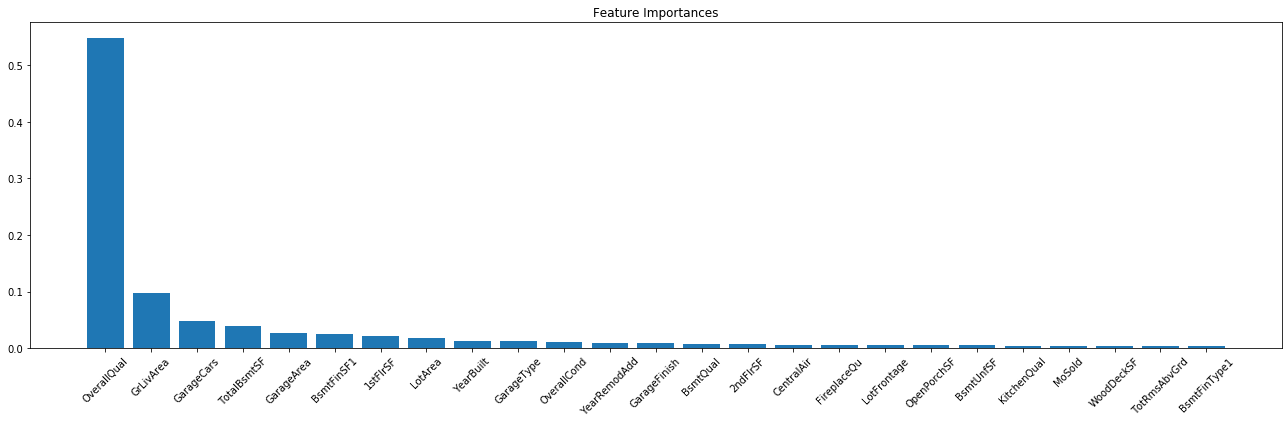

In [18]:
plt.figure(figsize=(18,6))
plt.bar(feature_df.feature[:25], feature_df.importance[:25])
plt.xticks(rotation=45)
plt.title('Feature Importances')
plt.tight_layout();

In [41]:
max_num_features = 31

In [42]:
lasso_r_squared_train = []
lasso_r_squared_test = []

ridge_r_squared_train = []
ridge_r_squared_test = []

rf_r_squared_train = []
rf_r_squared_test = []

In [43]:
# Going to run the three regression on an increasing number of features
for num_features in range(1,max_num_features):
    features = list(feature_df.iloc[:num_features, 0].values)
    data_partial = data.loc[:, features]
    for name, model in zip(['lasso', 'ridge', 'rf'],
                           [*models_3()]):
        if name == 'rf':
            pipeline = Pipeline([('scaler', None), ('estimator', model)])
        else:
            pipeline = Pipeline([('scaler', StandardScaler()), ('estimator', model)])
            
        scores = cross_validate(pipeline, data_partial, y_log, cv=3, scoring='r2', return_train_score=True)
        
        if name == 'lasso':
            lasso_r_squared_train.append(scores['train_score'].mean())
            lasso_r_squared_test.append(scores['test_score'].mean())
        
        elif name == 'ridge':
            ridge_r_squared_train.append(scores['train_score'].mean())
            ridge_r_squared_test.append(scores['test_score'].mean())
            
        elif name == 'rf':
            rf_r_squared_train.append(scores['train_score'].mean())
            rf_r_squared_test.append(scores['test_score'].mean())

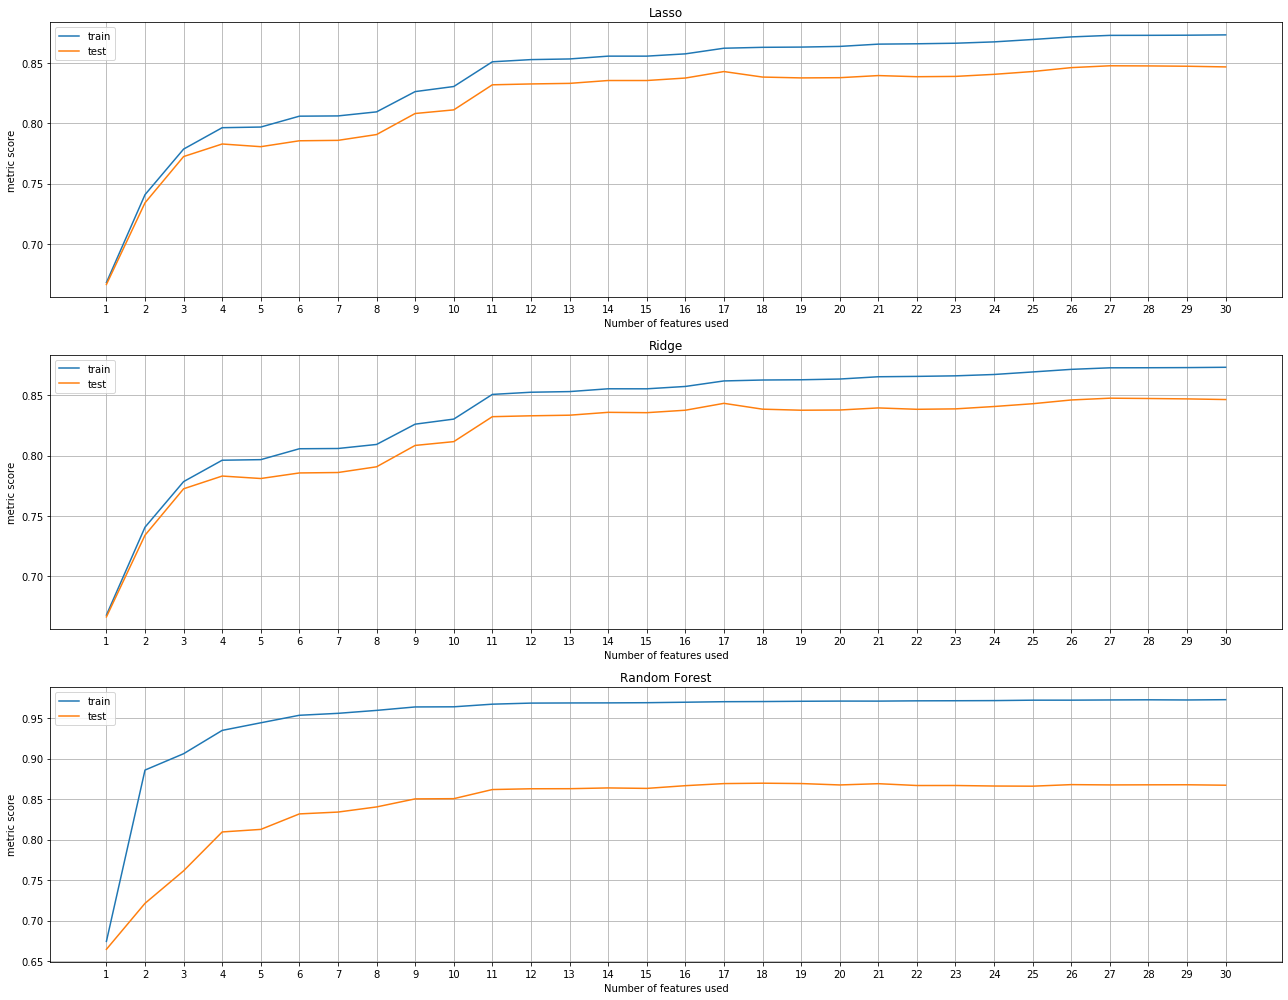

In [50]:
plt.figure(figsize=(18,14))

plt.subplot(3,1,1)
plt.plot(range(1, max_num_features), lasso_r_squared_train, label='train')
plt.plot(range(1, max_num_features), lasso_r_squared_test, label='test')
plt.legend()
plt.xlabel('Number of features used')
plt.ylabel('metric score')
plt.title('Lasso')
plt.xticks(range(1, max_num_features))
plt.grid()

plt.subplot(3,1,2)
plt.plot(range(1, max_num_features), ridge_r_squared_train, label='train')
plt.plot(range(1, max_num_features), ridge_r_squared_test, label='test')
plt.legend()
plt.xlabel('Number of features used')
plt.ylabel('metric score')
plt.title('Ridge')
plt.xticks(range(1, max_num_features))
plt.grid()

plt.subplot(3,1,3)
plt.plot(range(1, max_num_features), rf_r_squared_train, label='train')
plt.plot(range(1, max_num_features), rf_r_squared_test, label='test')
plt.legend()
plt.xlabel('Number of features used')
plt.ylabel('metric score')
plt.title('Random Forest')
plt.xticks(range(1, max_num_features))
plt.grid()

plt.tight_layout()

In [51]:
print(scores_compare['lasso_log_std'], scores_compare['ridge_log_std'], scores_compare['rf_log'])

0.835499500908426 0.8541745583165307 0.8673238879692261


#### Can reach the scores achieved from the entire dataset on a significantly small portion of it